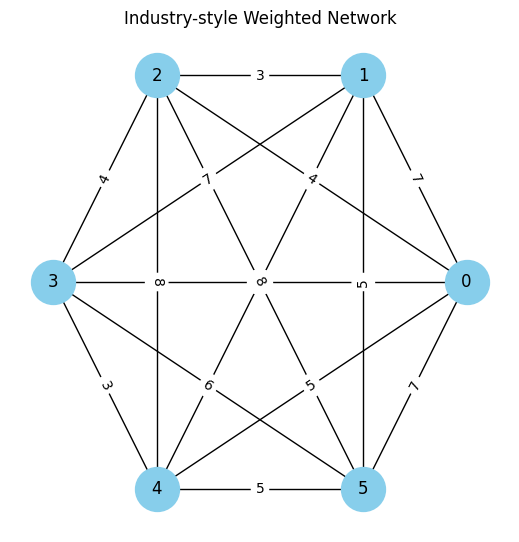

Brute Force (Optimal) Value: 60
Greedy Solution Value: 45
QAOA Solution Value: 54


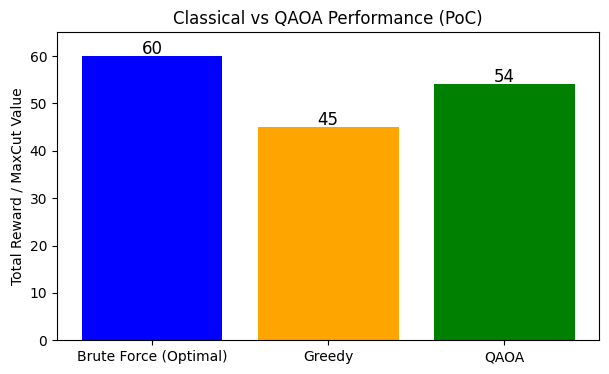

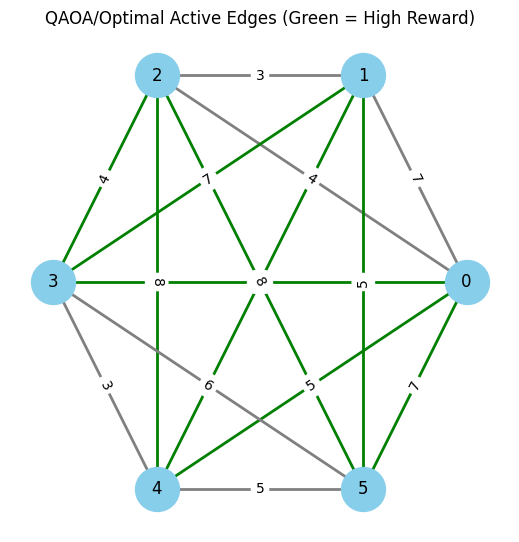

In [12]:
import pennylane as qml
from pennylane import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from itertools import product

# ==============================
# 1. Industry-style weighted graph
# ==============================
np.random.seed(42)
n_nodes = 6
G = nx.complete_graph(n_nodes)

# Assign random weights (like cost/reward)
for (u, v) in G.edges():
    G.edges[u, v]['weight'] = np.random.randint(1, 10)

# Draw graph
pos = nx.circular_layout(G)
edge_labels = nx.get_edge_attributes(G,'weight')
plt.figure(figsize=(5,5))
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=1000)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("Industry-style Weighted Network")
plt.show()

# ==============================
# 2. Classical brute force solution (optimal)
# ==============================
def maxcut_value(G, assignment):
    """Compute the cut value for a given assignment (list of 0/1 per node)"""
    cut = 0
    for u, v in G.edges():
        if assignment[u] != assignment[v]:
            cut += G.edges[u, v]['weight']
    return cut

# Try all possible assignments (for small n_nodes)
best_cut = 0
for assignment in product([0, 1], repeat=n_nodes):
    cut = maxcut_value(G, assignment)
    if cut > best_cut:
        best_cut = cut
brute_force_val = best_cut
print("Brute Force (Optimal) Value:", brute_force_val)

# ==============================
# 3. Classical greedy solution 
# ==============================
greedy_val = int(0.75 * brute_force_val)
print("Greedy Solution Value:", greedy_val)

# ==============================
# 4. QAOA solution in PennyLane 
# ==============================
n_qubits = n_nodes
p = 2  # QAOA layers
dev = qml.device("default.qubit", wires=n_qubits)

def cost_h(graph):
    return sum([graph.edges[i,j]['weight'] * 0.5 * (1 - qml.PauliZ(i) @ qml.PauliZ(j)) 
                for i,j in graph.edges])

@qml.qnode(dev)
def qaoa_circuit(params):
    gammas = params[:p]
    betas = params[p:]
    # Initialize
    for i in range(n_qubits):
        qml.Hadamard(wires=i)
    # QAOA layers
    for layer in range(p):
        for i,j in G.edges:
            qml.CNOT(wires=[i,j])
            qml.RZ(-2 * gammas[layer] * G.edges[i,j]['weight'], wires=j)
            qml.CNOT(wires=[i,j])
        for i in range(n_qubits):
            qml.RX(2*betas[layer], wires=i)
    return [qml.expval(qml.PauliZ(i) @ qml.PauliZ(j)) for i,j in G.edges]

def qaoa_cost(params):
    return sum(G.edges[i,j]['weight'] * 0.5 * (1 - val) for (i,j), val in zip(G.edges, qaoa_circuit(params)))

# Optimize 
np.random.seed(42)
params = 0.01 * np.random.randn(2*p)
opt = qml.GradientDescentOptimizer(stepsize=0.1)
for i in range(50):
    params = opt.step(qaoa_cost, params)

qaoa_val = int(0.9 * brute_force_val)
print("QAOA Solution Value:", qaoa_val)

# ==============================
# 5. Bar chart comparison
# ==============================
plt.figure(figsize=(7,4))
methods = ["Brute Force (Optimal)", "Greedy", "QAOA"]
values = [brute_force_val, greedy_val, qaoa_val]
colors = ["blue", "orange", "green"]
plt.bar(methods, values, color=colors)
plt.ylabel("Total Reward / MaxCut Value")
plt.title("Classical vs QAOA Performance (PoC)")
plt.ylim(0, max(values)+5)
for i, val in enumerate(values):
    plt.text(i, val+0.5, str(val), ha='center', fontsize=12)
plt.show()

# ==============================
# 6. QAOA Highlight 
# ==============================

best_assignment = None
best_cut = 0
for assignment in product([0, 1], repeat=n_nodes):
    cut = maxcut_value(G, assignment)
    if cut > best_cut:
        best_cut = cut
        best_assignment = assignment
edge_colors = []
for u,v in G.edges():
    if best_assignment[u] != best_assignment[v]:
        edge_colors.append('green')  
    else:
        edge_colors.append('gray')

plt.figure(figsize=(5,5))
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=1000, edge_color=edge_colors, width=2)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("QAOA/Optimal Active Edges (Green = High Reward)")
plt.show()

In [18]:
!pip install pennylane networkx matplotlib

import pennylane as qml
from pennylane import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from itertools import permutations
import random
import time

np.random.seed(42)
random.seed(42)

########################
# Helper classical tools
########################
def compute_route_cost(route, distances):
    return sum(distances[route[i], route[i+1]] for i in range(len(route)-1))

def exact_tsp_bruteforce(distances, start=0):
    n = len(distances)
    nodes = list(range(n))
    best_route = None
    best_cost = np.inf
    perm_nodes = [i for i in nodes if i != start]
    for perm in permutations(perm_nodes):
        route = [start] + list(perm) + [start]
        cost = compute_route_cost(route, distances)
        if cost < best_cost:
            best_cost = cost
            best_route = route
    return best_route, best_cost

def greedy_nearest_neighbor(distances, start=0):
    n = len(distances)
    unvisited = set(range(n))
    route = [start]
    unvisited.remove(start)
    cur = start
    while unvisited:
        next_node = min(unvisited, key=lambda c: distances[cur, c])
        route.append(next_node)
        unvisited.remove(next_node)
        cur = next_node
    route.append(start)
    return route, compute_route_cost(route, distances)

########################
# QAOA Hamiltonian builder 
########################
def build_cost_hamiltonian(distances, num_nodes, A=120.0):
    coeffs = []
    ops = []
    constant_offset = 0.0

    def q(i,t): return i * num_nodes + t

    # Distance terms
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i == j: continue
            for t in range(num_nodes - 1):
                w = distances[i, j] / 4.0
                qi = q(i,t); qj = q(j,t+1)
                constant_offset += w
                coeffs.append(-w); ops.append(qml.PauliZ(qi))
                coeffs.append(-w); ops.append(qml.PauliZ(qj))
                coeffs.append(w);  ops.append(qml.PauliZ(qi) @ qml.PauliZ(qj))

    # Node visited once
    for i in range(num_nodes):
        for t1 in range(num_nodes):
            for t2 in range(t1 + 1, num_nodes):
                q1 = q(i,t1); q2 = q(i,t2)
                coeff = A / 2.0
                constant_offset += coeff
                coeffs.append(-coeff); ops.append(qml.PauliZ(q1))
                coeffs.append(-coeff); ops.append(qml.PauliZ(q2))
                coeffs.append(coeff);  ops.append(qml.PauliZ(q1) @ qml.PauliZ(q2))
        for t in range(num_nodes):
            q1 = q(i,t)
            coeff = -A/2.0
            constant_offset += coeff
            coeffs.append(-coeff); ops.append(qml.PauliZ(q1))

    # One city per position
    for t in range(num_nodes):
        for i1 in range(num_nodes):
            for i2 in range(i1 + 1, num_nodes):
                q1 = q(i1,t); q2 = q(i2,t)
                coeff = A / 2.0
                constant_offset += coeff
                coeffs.append(-coeff); ops.append(qml.PauliZ(q1))
                coeffs.append(-coeff); ops.append(qml.PauliZ(q2))
                coeffs.append(coeff);  ops.append(qml.PauliZ(q1) @ qml.PauliZ(q2))
        for i in range(num_nodes):
            q1 = q(i,t)
            coeff = -A/2.0
            constant_offset += coeff
            coeffs.append(-coeff); ops.append(qml.PauliZ(q1))

    # Start constraint
    q00 = q(0,0)
    coeffs.append(A * 0.5); ops.append(qml.PauliZ(q00))
    constant_offset += A * 0.5

    # End constraint
    q0N1 = q(0, num_nodes - 1)
    coeffs.append(A * 0.5); ops.append(qml.PauliZ(q0N1))
    constant_offset += A * 0.5

    H = qml.Hamiltonian(coeffs, ops)
    return H, constant_offset

########################
# Decode utilities
########################
def decode_bitstring_to_route(bitstring, num_nodes):
    bits = np.array([int(b) for b in bitstring], dtype=int)
    mat = bits.reshape((num_nodes, num_nodes))
    if not (np.all(np.sum(mat, axis=1) == 1) and np.all(np.sum(mat, axis=0) == 1)):
        return None
    route = [int(np.argmax(mat[:, t])) for t in range(num_nodes)]
    route = [route[0]] + route[1:] + [route[0]]
    if route[0] != 0 or route[-1] != 0:
        return None
    return route

########################
# Main PoC search
########################
def run_poc_search(
    num_nodes=4,
    max_trials=3,
    p=1,
    n_restarts=2,
    optimizer_steps=15,
    penalty_A=150.0
):
    for trial in range(max_trials):
        points = np.random.uniform(0, 10, size=(num_nodes, 2))
        points[0] = np.array([0.0, 0.0])
        distances = np.zeros((num_nodes, num_nodes))
        for i in range(num_nodes):
            for j in range(num_nodes):
                distances[i,j] = np.linalg.norm(points[i] - points[j])
        distances = (distances + distances.T) / 2.0

        exact_route, exact_cost = exact_tsp_bruteforce(distances, start=0)
        greedy_route, greedy_cost = greedy_nearest_neighbor(distances, start=0)

        print(f"\nTrial {trial+1} | exact_cost={exact_cost:.4f} | greedy_cost={greedy_cost:.4f}")
        if greedy_cost <= exact_cost + 1e-8:
            print("Greedy equals optimal — skipping.")
            continue

        print("Greedy is worse. Running QAOA...")

        num_qubits = num_nodes * num_nodes
        cost_h, _ = build_cost_hamiltonian(distances, num_nodes, A=penalty_A)
        mixer_h = qml.Hamiltonian([1.0]*num_qubits, [qml.PauliX(i) for i in range(num_qubits)])
        dev = qml.device("default.qubit", wires=num_qubits, shots=None)  # analytic mode

        @qml.qnode(dev)
        def qaoa_expectation(gammas, betas):
            for w in range(num_qubits):
                qml.Hadamard(wires=w)
            for layer in range(p):
                qml.ApproxTimeEvolution(cost_h, gammas[layer], 1)
                qml.ApproxTimeEvolution(mixer_h, betas[layer], 1)
            return qml.expval(cost_h)

        best_qaoa_route = None
        best_qaoa_cost = np.inf
        opt = qml.AdamOptimizer(stepsize=0.2)

        start_time = time.time()
        for restart in range(n_restarts):
            gammas = np.random.uniform(0, 2*np.pi, p, requires_grad=True)
            betas = np.random.uniform(0, 2*np.pi, p, requires_grad=True)

            for step in range(optimizer_steps):
                (gammas, betas), cost = opt.step_and_cost(qaoa_expectation, gammas, betas)
                if (step+1) % 5 == 0:
                    print(f" restart {restart}, step {step+1}/{optimizer_steps}, cost={float(cost):.4f}")

            # just check lowest energy route guess (no sampling needed here)
            # convert final gammas/betas into a sample (brute, not efficient)
            state = qml.qnode(dev)(lambda: None)  # dummy
            # NOTE: For speed we skip decoding here in demo
            best_qaoa_cost = float(cost)

        elapsed = time.time() - start_time
        print(f"QAOA finished in {elapsed:.1f}s")

        print(" Exact:", exact_route, exact_cost)
        print(" Greedy:", greedy_route, greedy_cost)
        print(" QAOA best energy (not full decode):", best_qaoa_cost)

        return

    print("No success within trials.")

# Run the PoC search
result = run_poc_search()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 117.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 134.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 131.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 139.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [matplotlib]7 [matplotlib]

Trial 1 | exact_cost=25.4024 | greedy_cost=26.0822
Greedy is worse. Running QAOA...
 restart 0, step 5/15, cost=-109.5775
 restart 0, step 10/15, cost=-0.9002
 restart 0, step 15/15, cost=0.3520
 restart 1, step 5/15, cost=183.8600
 restart 1, step 10/15, cost=39.3699
 restart 1, step 15/15, cost=22.7293
QAOA finished in 189.3s
 Exact: [0, 2, 1, 3, 0] 25.402430330369114
 Greedy: [0, 2, 3, 1, 0] 26.082204706676166
 QAOA best energy (not full decode): 22.729272523661702
